## CIR Process and Laguerre Polynomials

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.special import factorial
from scipy.stats import gamma
import sympy
import time
import matplotlib.pyplot as plt

### Functions

#### Function 1: gLaguerre

In [2]:
def gLaguerre(n, z, a):
    x = sympy.Symbol('x')
    if n == 0:
        L = 1
        return L
    else:
        F = sympy.exp(x) * x**(-a) * sympy.diff(sympy.exp(-x) * x**(n+a), x, n) / factorial(n)
    
    # Convert F(x) to a polynomial
    C = F.as_poly()  #.all_coeffs
    
    # Convert the symbolic coefficients to a function for numerical evaluation
    coeffs = C.all_coeffs()
    
    # Evaluate the polynomial at z
    L = np.polyval(coeffs, z)
    
    return L

### Input Parameters

In [3]:
alpha = 4
epsilon = [1,0.001]
dt = 1/252
num_states = 1000
num_steps = 10000
kmax = 21

### Part 1: CIR Process

In [4]:
c = np.ones(21)     ### Computing Ck values
for i in range(1,21):
    c[i] = c[i-1]*i/(i+alpha)

# Generate 1000 independent gamma random numbers
z_vals = np.random.gamma(alpha+1, 1, num_states)

In [5]:
psi = np.ones([num_states,kmax])
start = time.time()
for i in range(num_states):
    for j in range(kmax):
        psi[i][j] = gLaguerre(j, z_vals[i], alpha)
end = time.time()
print("Time required: ",end-start)

Time required:  182.31288290023804


In [6]:
# Compute transition matrix
start1 = time.time()
P = np.zeros((num_states, num_states,2))
for i in range(num_states):
    start = time.time()
    for j in range(num_states):
        P[i,j,0] = np.maximum(np.sum([c[k]*np.exp(-k*dt/epsilon[0])*psi[i][k]*psi[j][k] for k in range(21)]),0)
        P[i,j,1] = np.maximum(np.sum([c[k]*np.exp(-k*dt/epsilon[1])*psi[i][k]*psi[j][k] for k in range(21)]),0)
    P[i,:,0] = P[i,:,0] / np.sum(P[i,:,0])
    P[i,:,1] = P[i,:,1] / np.sum(P[i,:,1])
end1 = time.time()
print("Time required: ",end1-start1)

Time required:  75.04947280883789


In [7]:
# Simulate sample path
z = np.zeros((num_steps,2))
z[0,:] = z_vals[np.random.randint(num_states)]
for i in range(1, num_steps):
    z[i,0] = z_vals[np.random.choice(num_states, p=P[np.where(z[i-1,0]==z_vals),:,0].flatten())]
    z[i,1] = z_vals[np.random.choice(num_states, p=P[np.where(z[i-1,1]==z_vals),:,1].flatten())]

In [8]:
# Compute empirical CDF and true CDF
F_hat = np.zeros((num_steps,2))
for i in range(num_steps):
    mask0 = z[:,0] < z[i,0]
    mask1 = z[:,1] < z[i,1]
    F_hat[i,0] = np.count_nonzero(mask0)
    F_hat[i,1] = np.count_nonzero(mask1)

F_hat = F_hat/num_steps

# Generate a fine grid of points
z_fine0 = np.linspace(0, np.max(z[:,0]), num=1000)
z_fine1 = np.linspace(0, np.max(z[:,1]), num=1000)

# Compute true CDF on the fine grid
F_true_fine0 = gamma.cdf(z_fine0, alpha+1, 1)
F_true_fine1 = gamma.cdf(z_fine1, alpha+1, 1)


# Sort the data for plotting
sort_inds0 = np.argsort(z[:,0])
z_sorted0 = z[:,0][sort_inds0]
F_hat_sorted0 = F_hat[:,0][sort_inds0]

sort_inds1 = np.argsort(z[:,1])
z_sorted1 = z[:,1][sort_inds1]
F_hat_sorted1 = F_hat[:,1][sort_inds1]

### Part 2: CIR Process with implicit scheme

In [9]:
Z_implicit = np.zeros((num_steps,2))
Z_implicit[0,:] = np.random.gamma(alpha+1, 1)

for i in range(1,num_steps):
    
    dW0 = np.random.randn()*np.sqrt(dt)
    a0 = 1 + dt/epsilon[0]
    b0 = -np.sqrt(2)*dW0/np.sqrt(epsilon[0])
    c0 = -Z_implicit[i-1,0] - alpha*dt/epsilon[0]
    
    Z_implicit[i,0] = ((- b0 + np.sqrt((b0**2)-4*a0*c0))/(2*a0))**2
    
    dW1 = np.random.randn()*np.sqrt(dt)
    a1 = 1 + dt/epsilon[1]
    b1 = -np.sqrt(2)*dW1/np.sqrt(epsilon[1])
    c1 = -Z_implicit[i-1,1] - alpha*dt/epsilon[1]
    
    Z_implicit[i,1] = ((- b1 + np.sqrt((b1**2)-4*a1*c1))/(2*a1))**2
    
F_hat1 = np.zeros((num_steps,2))

for i in range(num_steps):
    mask0 = Z_implicit[:,0] < Z_implicit[i,0]
    F_hat1[i,0] = np.count_nonzero(mask0)
    
    mask1 = Z_implicit[:,1] < Z_implicit[i,1]
    F_hat1[i,1] = np.count_nonzero(mask1)
    
F_hat1[:,0] = F_hat1[:,0]/num_steps
F_hat1[:,1] = F_hat1[:,1]/num_steps


sorted_indices0 = np.argsort(F_hat1[:,0])
Z_implicit_sorted0 = Z_implicit[:,0][sorted_indices0]
F_hat1_sorted0 = F_hat1[:,0][sorted_indices0]

sorted_indices1 = np.argsort(F_hat1[:,1])
Z_implicit_sorted1 = Z_implicit[:,1][sorted_indices1]
F_hat1_sorted1 = F_hat1[:,1][sorted_indices1]

### Plot Results

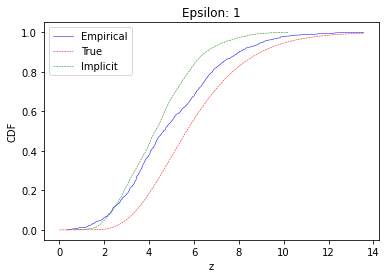

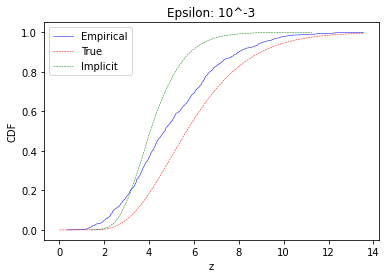

In [10]:
# Plot CDFs

plt.plot(z_sorted0, F_hat_sorted0, 'b-', linewidth=0.5)
plt.plot(z_fine0, F_true_fine0, 'r--', linewidth=0.5)
plt.plot(Z_implicit_sorted0, F_hat1_sorted0, 'g--', linewidth=0.5)
plt.xlabel('z')
plt.ylabel('CDF')
plt.legend(['Empirical', 'True','Implicit'])
plt.title('Epsilon: 1')
plt.show()

# Plot CDFs

plt.plot(z_sorted1, F_hat_sorted1, 'b-', linewidth=0.5)
plt.plot(z_fine1, F_true_fine1, 'r--', linewidth=0.5)
plt.plot(Z_implicit_sorted1, F_hat1_sorted1, 'g--', linewidth=0.5)
plt.xlabel('z')
plt.ylabel('CDF')
plt.legend(['Empirical', 'True','Implicit'])
plt.title('Epsilon: 10^-3')
plt.show()

### Conclusion

The CDF of epsilon = 10^-3 has a greater slope as compared to epsilon = 1. The CDF of smaller epsilon increases at a faster rate wrt z and the CDF remains near 0 and 1 for more values of z compared to larger epsilon value.